The code is written with the help of ChatGPT.\
Similar work is done here: https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb

In [86]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cv2 import imwrite
from PIL import Image

In [2]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)   # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log-variance of latent space

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_reconstructed = torch.sigmoid(self.fc2(h))  # Sigmoid for output between 0 and 1
        return x_reconstructed

# Define the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar) #For numerical stability
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


In [3]:
# VAE Loss Function
def vae_loss(x, x_reconstructed, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    recon_loss = criterion(x_reconstructed, x)
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [4]:
# Parameters
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 10
learning_rate = 1e-3

# Data Preparation
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize Model
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)  # Flatten MNIST images
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae(data)
        loss = vae_loss(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 164.5123
Epoch 2, Loss: 121.2050
Epoch 3, Loss: 114.4649
Epoch 4, Loss: 111.6075
Epoch 5, Loss: 109.8570
Epoch 6, Loss: 108.7003
Epoch 7, Loss: 107.8916
Epoch 8, Loss: 107.2667
Epoch 9, Loss: 106.7437
Epoch 10, Loss: 106.2698


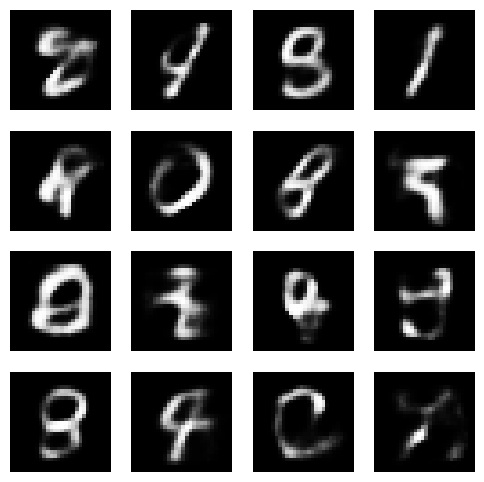

In [6]:
vae.eval()
with torch.no_grad():
    # Generate random samples from latent space
    z = torch.randn(16, latent_dim)  # Sample from standard normal
    generated_images = vae.decoder(z).view(-1, 1, 28, 28)

# Visualize the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


Generating new-sample from the both seen and unseen samples

In [10]:
def save(name,tensor):
    tensor = (five*255).to(torch.uint8)
    image = Image.fromarray(tensor.numpy())
    image.save(name)

In [7]:
fives = [train_dataset[i][0] for i in range(300,500) if train_dataset[i][1] == 5]

0


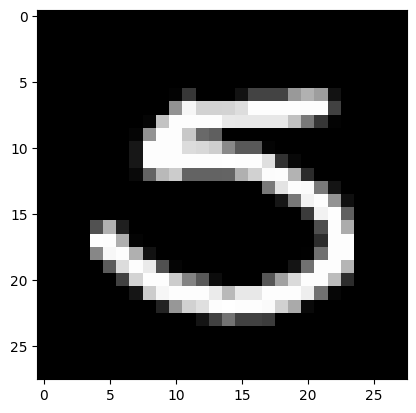

1


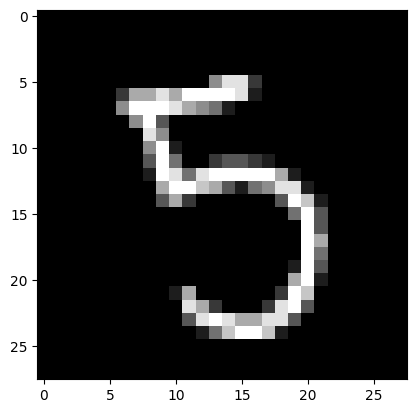

2


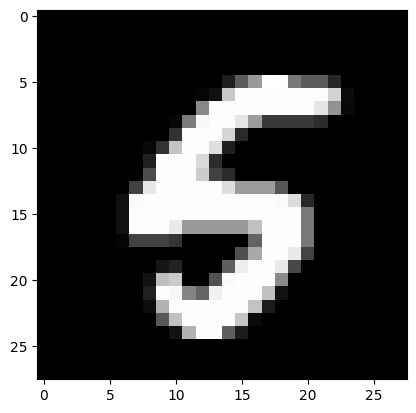

3


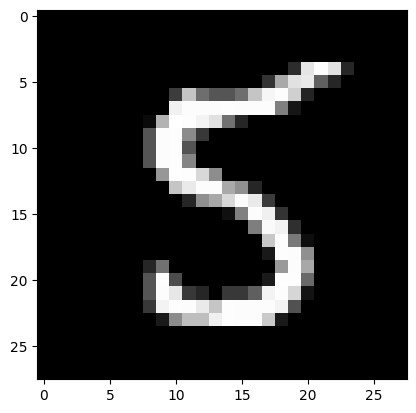

4


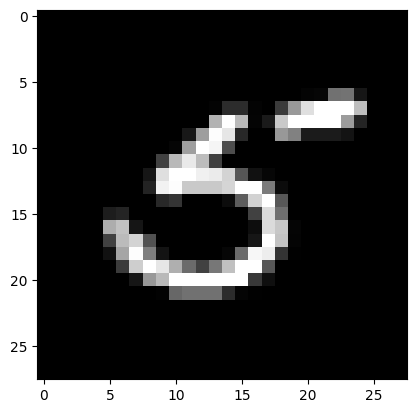

5


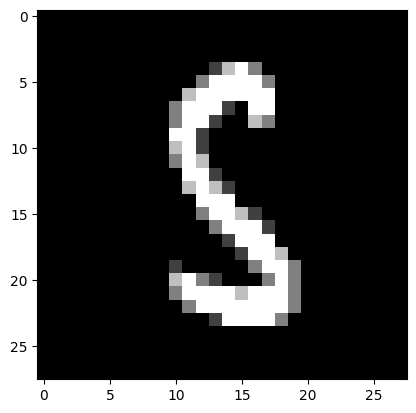

6


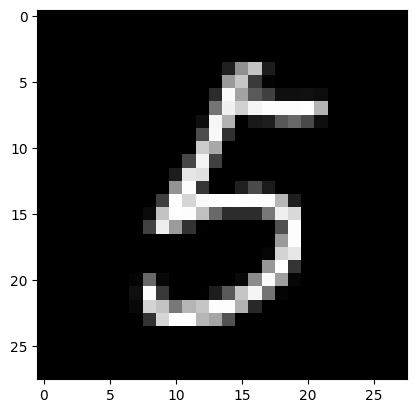

7


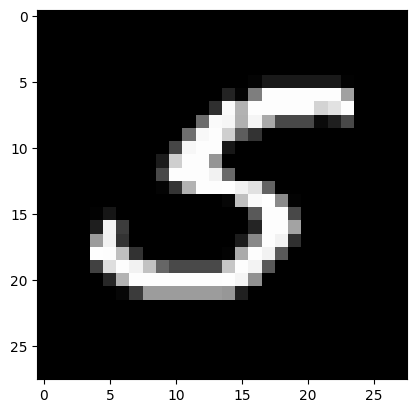

8


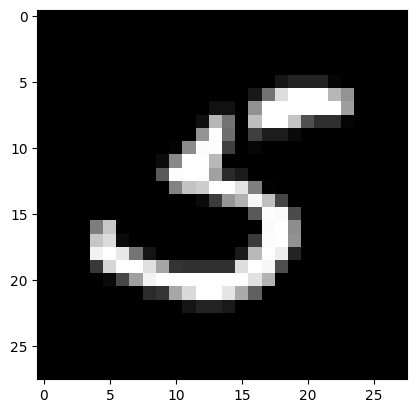

9


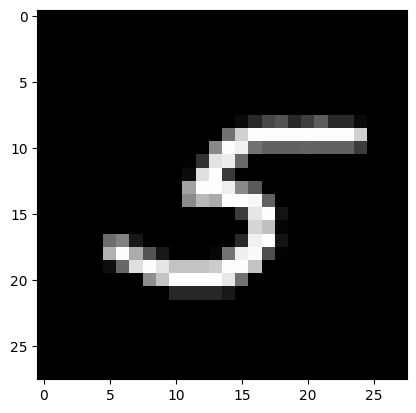

10


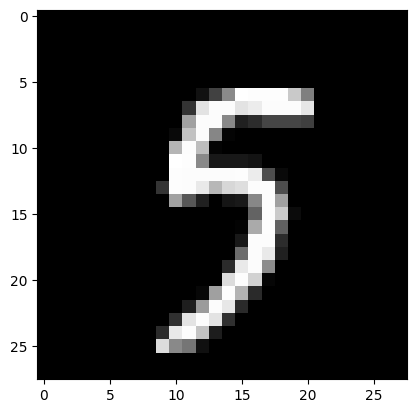

11


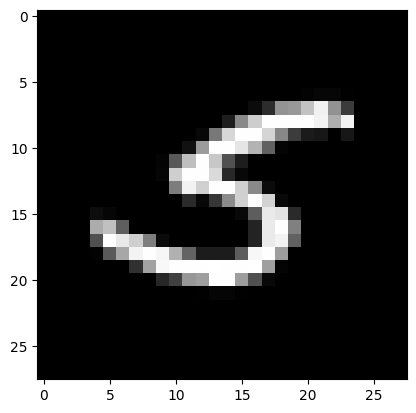

12


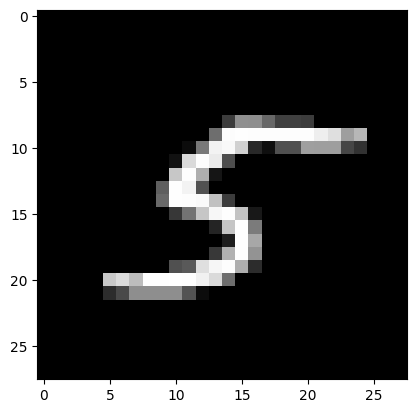

13


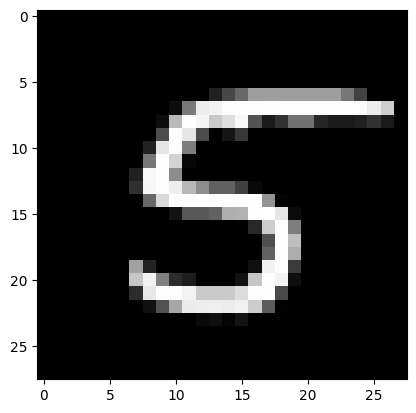

14


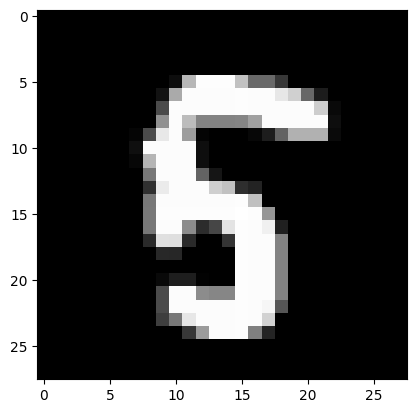

15


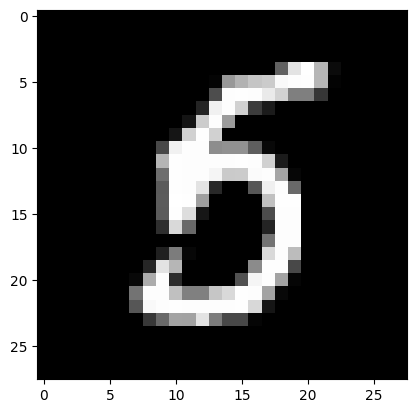

In [8]:
a = 0
for five in fives:
    print(a)
    plt.imshow(five[0],cmap="gray")
    plt.show()
    a += 1

In [84]:
five = fives[1][0] #Choosez a example
save("train_five.png",five)

In [85]:
plt.imshow(five,cmap="gray")
plt.axis("off")
plt.title("Example '5' from Train")
plt.show()

/tmp/ipykernel_88336/1948865789.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


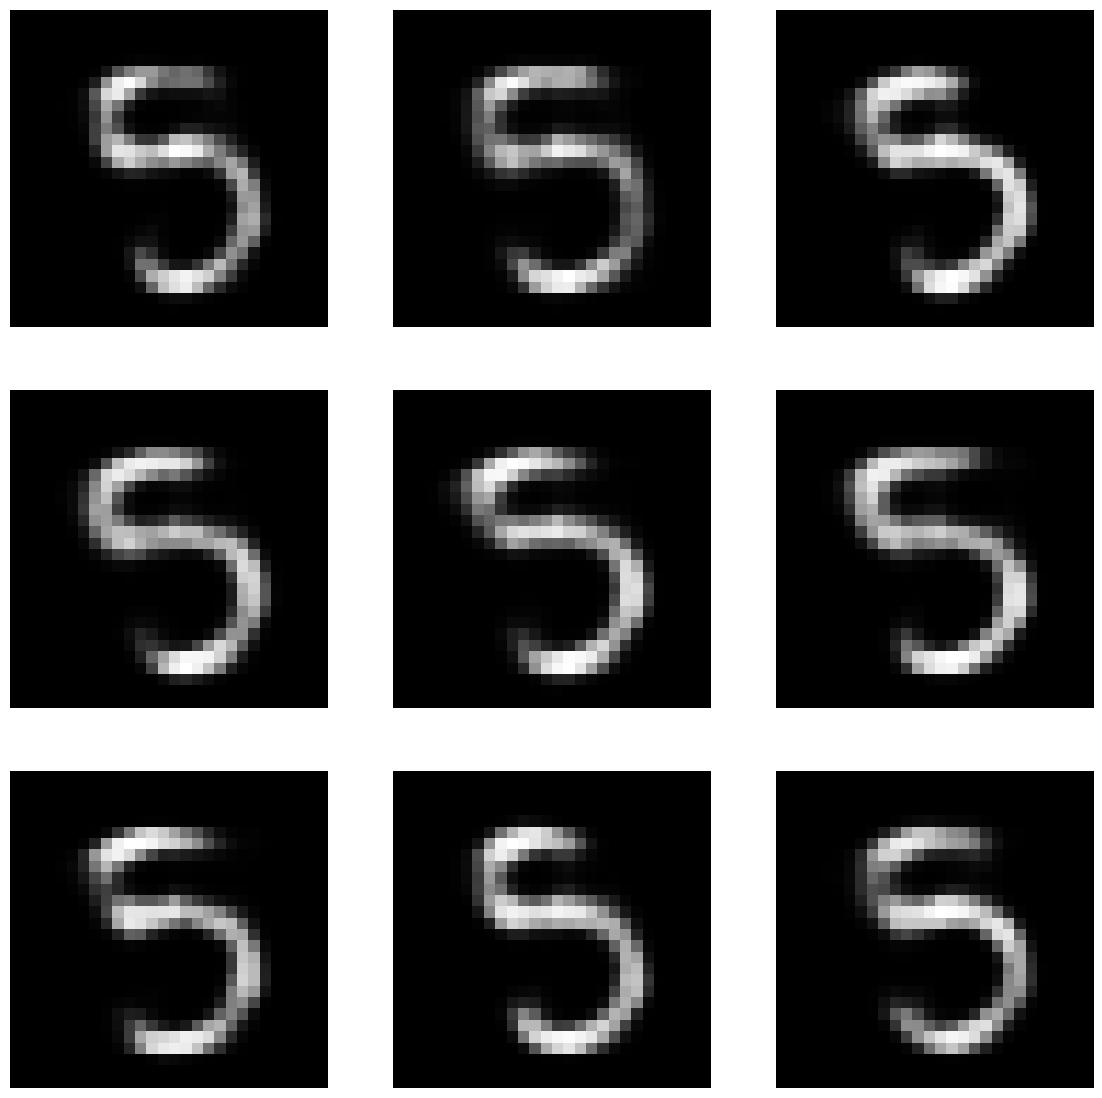

In [220]:
vae.eval()
with torch.no_grad():
    mu, logvar = vae.encoder(five.view(-1, input_dim))

generated_images = []
std = torch.exp(0.5 * logvar)
vae.eval()
with torch.no_grad():
    for i in range(16):
        epsilon = torch.randn_like(std)
        latent = mu + epsilon*std
        image = vae.decoder(latent)
        generated_images.append(image.view(-1, 1, 28, 28)[0][0])


fig, axes = plt.subplots(3,3, figsize=(14,14))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

In [91]:
vae.eval()
with torch.no_grad():
    mu, logvar = vae.encoder(five.view(-1, input_dim))
    latent = mu
    image = vae.decoder(latent)
    mean = image.view(-1, 1, 28, 28)[0][0]
    std = torch.exp(0.5 * logvar)

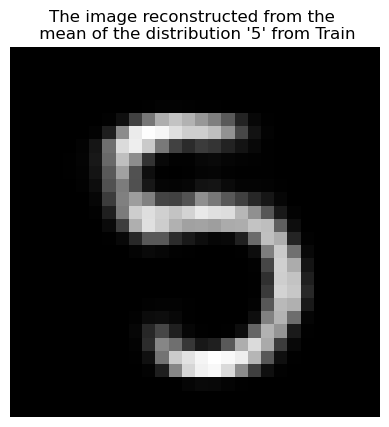

In [223]:
plt.imshow(mean,cmap="gray")
plt.axis("off")
plt.title("The image reconstructed from the \n mean of the distribution '5' from Train")
plt.show()

In [98]:
from PIL import Image
#We will create a gif
images = []

epsilon = torch.randn_like(std)
with torch.no_grad():
    for a in range(100):
        latent = mu + (a*0.1)*epsilon*std
        image = vae.decoder(latent).view(-1, 1, 28, 28)[0][0]
        images.append(image)

In [99]:
transform = transforms.ToPILImage()
pil_images = [transform(img) for img in images]

In [100]:
pil_images[0].save(
    "5output_3.gif",
    save_all=True,
    append_images=pil_images[1:],  # Add the rest of the images
    duration=200,             # Duration of each frame in milliseconds
    loop=1                    # 0 for infinite loop
)

In [66]:
transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [67]:
twos = [test_dataset[i][0] for i in range(200) if train_dataset[i][1] == 2]
two = twos[1][0]

In [87]:
plt.imshow(two,cmap="gray")
plt.axis("off")
plt.title("Example '2' from Test")
plt.show()

/tmp/ipykernel_88336/1057013961.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


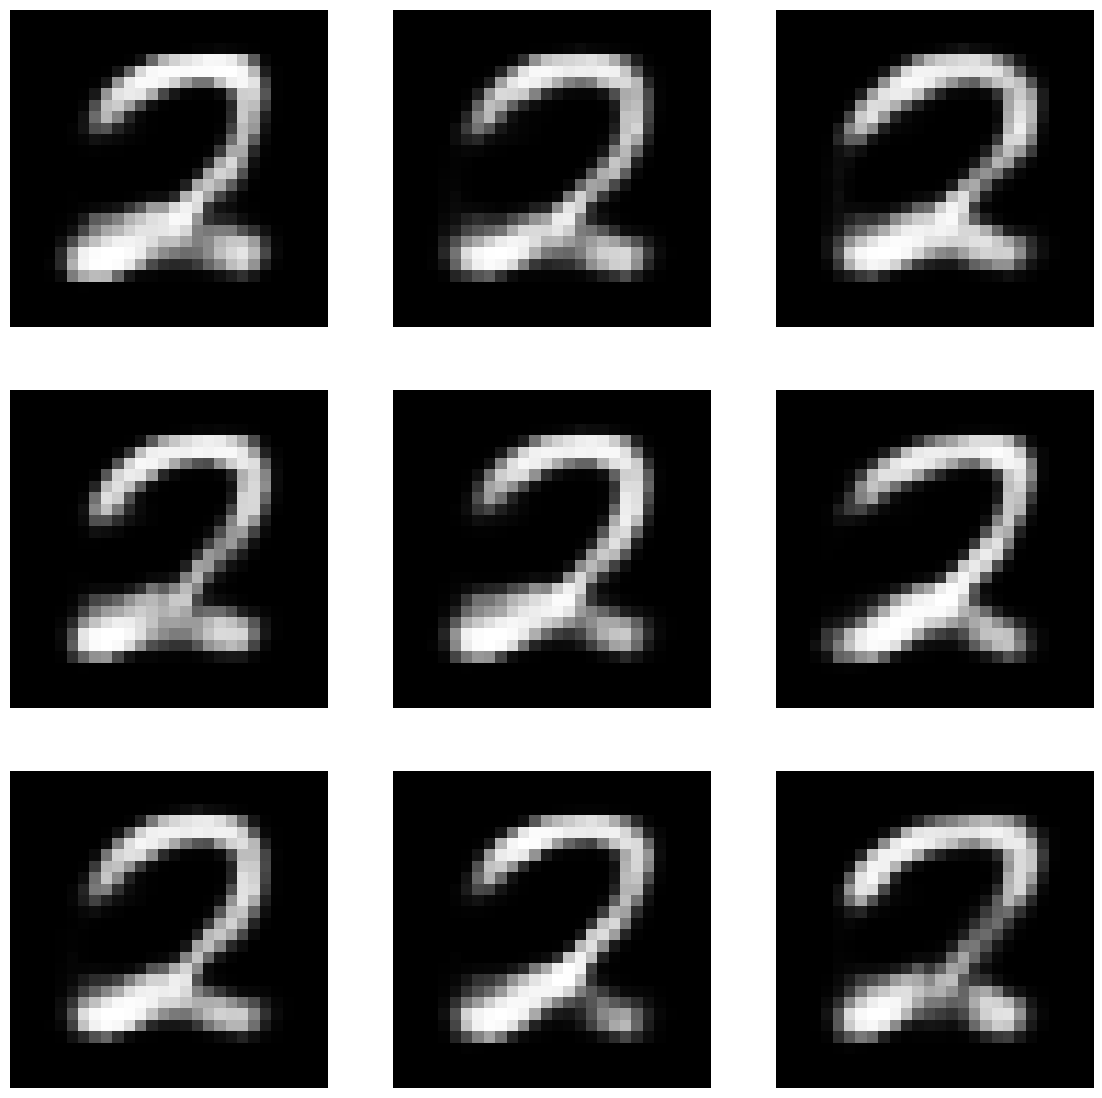

In [239]:
vae.eval()
with torch.no_grad():
    mu, logvar = vae.encoder(two.view(-1, input_dim))

generated_images = []
std = torch.exp(0.5 * logvar)
vae.eval()
with torch.no_grad():
    for i in range(16):
        epsilon = torch.randn_like(std)
        latent = mu + epsilon*std
        image = vae.decoder(latent)
        generated_images.append(image.view(-1, 1, 28, 28)[0][0])


fig, axes = plt.subplots(3,3, figsize=(14,14))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

In [240]:
with torch.no_grad():
    latent = mu
    image = vae.decoder(latent)
    mean = image.view(-1, 1, 28, 28)[0][0]

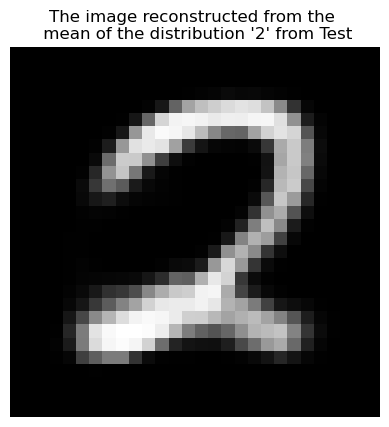

In [241]:
plt.imshow(mean,cmap="gray")
plt.axis("off")
plt.title("The image reconstructed from the \n mean of the distribution '2' from Test")
plt.show()

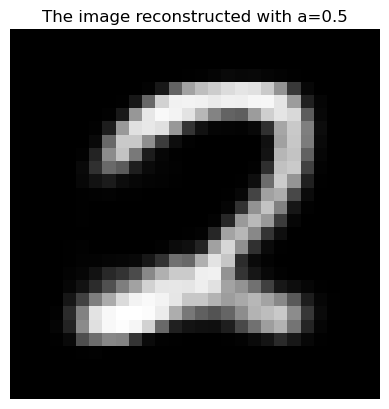

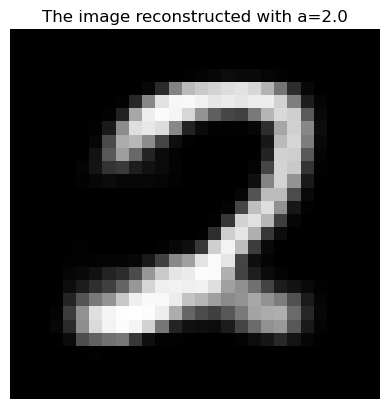

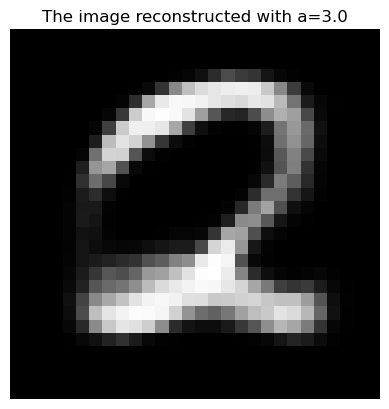

In [242]:
with torch.no_grad():
    for a in [0.5,2,3]:
        epsilon = torch.randn_like(std)
        latent = mu + (a/2)*epsilon*std
        image = vae.decoder(latent).view(-1, 1, 28, 28)[0][0]
        plt.imshow(image,cmap="gray")
        plt.axis("off")
        plt.title(f"The image reconstructed with a={a:.1f}")
        plt.show()

Some configuraitons I will apply myself

In [69]:
# Parameters
input_dim = 28 * 28
hidden_dim = 200
latent_dim = 2
batch_size = 128
epochs = 10
learning_rate = 1e-3

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)  # Flatten MNIST images
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae(data)
        loss = vae_loss(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 198.4669
Epoch 2, Loss: 171.1167
Epoch 3, Loss: 166.3183
Epoch 4, Loss: 163.8743
Epoch 5, Loss: 162.2682
Epoch 6, Loss: 161.0187
Epoch 7, Loss: 160.0136
Epoch 8, Loss: 159.1000
Epoch 9, Loss: 158.3093
Epoch 10, Loss: 157.6019


In [8]:
#Deep Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*20)
        self.fc2 = nn.Linear(hidden_dim*20, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)   # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log-variance of latent space

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*20)
        self.fc3 = nn.Linear(hidden_dim*20, output_dim)

    def forward(self, z):
        h1 = torch.relu(self.fc1(z))
        h2 = torch.relu(self.fc2(h1))
        x_reconstructed = torch.sigmoid(self.fc3(h2))  # Sigmoid for output between 0 and 1
        return x_reconstructed

# Define the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar) #For numerical stability
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


In [71]:
# Parameters
input_dim = 28 * 28
hidden_dim = 20
latent_dim = 2
batch_size = 128
epochs = 10
learning_rate = 1e-3

vae_deep = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae_deep.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(epochs):
    vae_deep.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)  # Flatten MNIST images
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae_deep(data)
        loss = vae_loss(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 194.8972
Epoch 2, Loss: 165.5311
Epoch 3, Loss: 160.8579
Epoch 4, Loss: 157.9670
Epoch 5, Loss: 155.9662
Epoch 6, Loss: 154.2526
Epoch 7, Loss: 152.9021
Epoch 8, Loss: 151.5780
Epoch 9, Loss: 150.6278
Epoch 10, Loss: 149.7313


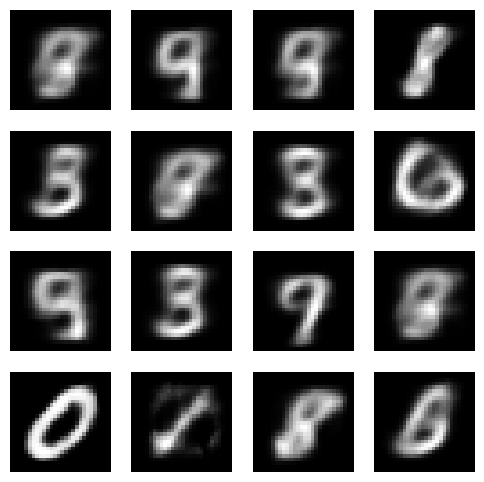

In [72]:
vae.eval()
with torch.no_grad():
    # Generate random samples from latent space
    z = torch.randn(16, latent_dim)  # Sample from standard normal
    generated_images = vae.decoder(z).view(-1, 1, 28, 28)

# Visualize the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

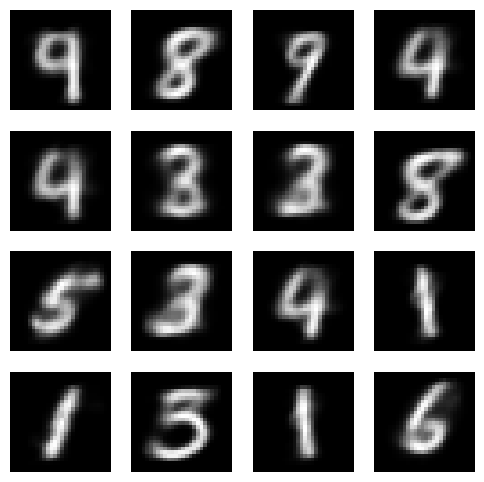

In [73]:
vae_deep.eval()
with torch.no_grad():
    # Generate random samples from latent space
    z = torch.randn(16, latent_dim)  # Sample from standard normal
    generated_images = vae_deep.decoder(z).view(-1, 1, 28, 28)

# Visualize the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

In [13]:
import numpy as np
from scipy.stats import norm

In [18]:
grid_size = 64  # Number of points along each axis
u_range = np.linspace(0.01, 0.99, grid_size)  # Avoid 0 and 1 for numerical stability
# Compute the inverse CDF (quantile function) for the grid
z_coords = norm.ppf(u_range)  # Maps uniform probabilities to Gaussian values
# Create a grid of latent points
z_grid = np.array([[z1, z2] for z1 in z_coords for z2 in z_coords])
# Convert the grid to a PyTorch tensor
z_grid_tensor = torch.tensor(z_grid, dtype=torch.float32)

In [ ]:
with torch.no_grad():
    generated_images = vae.decoder(z_grid_tensor).numpy()

# Visualize the manifold
img_dim = 28  # Assuming MNIST
canvas = np.zeros((grid_size * img_dim, grid_size * img_dim))

for i, (z1, z2) in enumerate(z_grid):
    x = i % grid_size
    y = i // grid_size
    canvas[y*img_dim:(y+1)*img_dim, x*img_dim:(x+1)*img_dim] = generated_images[i].reshape(img_dim, img_dim)

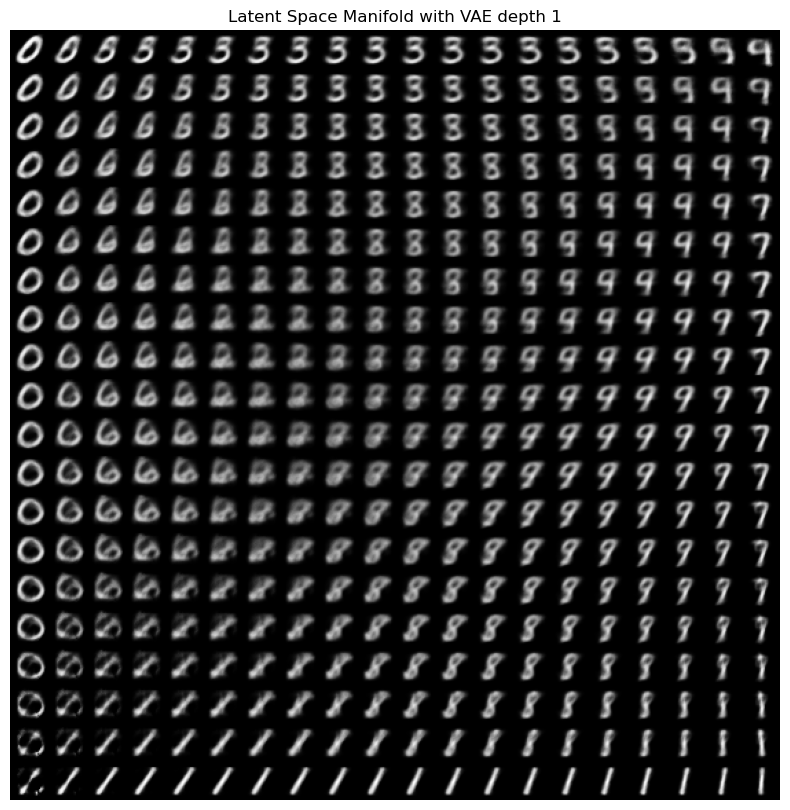

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title('Latent Space Manifold with VAE depth 1')
plt.show()

In [88]:
with torch.no_grad():
    generated_images = vae_deep.decoder(z_grid_tensor).numpy()

# Visualize the manifold
img_dim = 28  # Assuming MNIST
canvas = np.zeros((grid_size * img_dim, grid_size * img_dim))

for i, (z1, z2) in enumerate(z_grid):
    x = i % grid_size
    y = i // grid_size
    canvas[y*img_dim:(y+1)*img_dim, x*img_dim:(x+1)*img_dim] = generated_images[i].reshape(img_dim, img_dim)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title('Latent Space Manifold with VAE depth 2')
plt.savefig("Latent Space Manifold with VAE depth 2.png",dpi=1200, bbox_inches='tight', pad_inches=0.1)
plt.show()

Crazy!

Now we try a different dataset

In [9]:
from torchvision.datasets import FashionMNIST
train_dataset = FashionMNIST(root='./data/FashonMNIST', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Parameters
input_dim = 28 * 28
hidden_dim = 20
latent_dim = 2
batch_size = 128
epochs = 10
learning_rate = 1e-3

vae_deep = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae_deep.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(epochs):
    vae_deep.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)  # Flatten MNIST images
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae_deep(data)
        loss = vae_loss(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 299.8794
Epoch 2, Loss: 272.9243
Epoch 3, Loss: 268.8415
Epoch 4, Loss: 266.4209
Epoch 5, Loss: 264.4410
Epoch 6, Loss: 263.0213
Epoch 7, Loss: 261.9173
Epoch 8, Loss: 261.1331
Epoch 9, Loss: 260.5399
Epoch 10, Loss: 260.0353


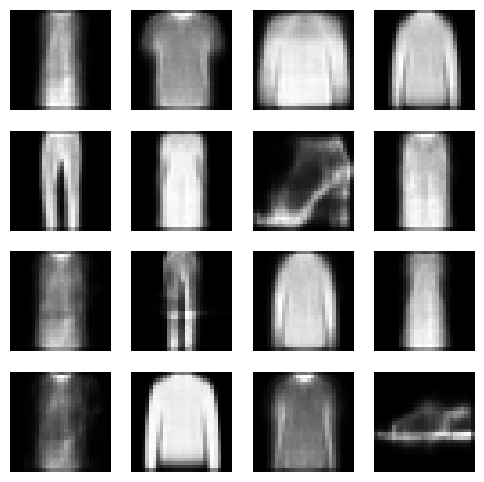

In [11]:
vae_deep.eval()
with torch.no_grad():
    # Generate random samples from latent space
    z = torch.randn(16, latent_dim)  # Sample from standard normal
    generated_images = vae_deep.decoder(z).view(-1, 1, 28, 28)

# Visualize the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

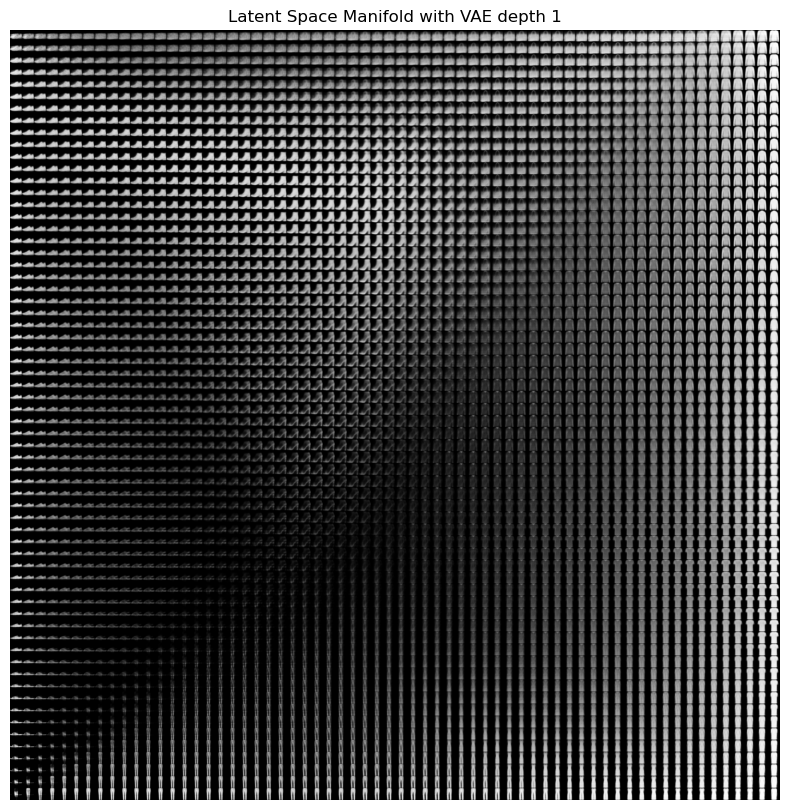

In [20]:
vae_deep.eval()
with torch.no_grad():
    generated_images = vae_deep.decoder(z_grid_tensor).numpy()

# Visualize the manifold
img_dim = 28  # Assuming MNIST
canvas = np.zeros((grid_size * img_dim, grid_size * img_dim))

for i, (z1, z2) in enumerate(z_grid):
    x = i % grid_size
    y = i // grid_size
    canvas[y*img_dim:(y+1)*img_dim, x*img_dim:(x+1)*img_dim] = generated_images[i].reshape(img_dim, img_dim)
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title('Latent Space Manifold with VAE depth 1')
plt.show()

CIFAR-10 Time

In [47]:
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root='./data/CIFAR10', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [57]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # (32, 32) -> (16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # (16, 16) -> (8, 8)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        
        # Decoder: Transposed Convolutional layers
        self.decoder_input = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # (8, 8) -> (16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # (16, 16) -> (32, 32)
            nn.Sigmoid()  # Output values in [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z).view(-1, 64, 8, 8)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [58]:
#Using the ConvVAE, courtesy to ChatGPT
# Parameters

latent_dim = 2
epochs = 10
learning_rate = 1e-3

vae_conv = ConvVAE(latent_dim)
optimizer = optim.Adam(vae_conv.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(epochs):
    vae_conv.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae_conv(data)
        loss = vae_loss(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 1972.4951
Epoch 2, Loss: 1956.7521
Epoch 3, Loss: 1956.3039
Epoch 4, Loss: 1955.9581
Epoch 5, Loss: 1955.7621
Epoch 6, Loss: 1955.5996
Epoch 7, Loss: 1955.3856
Epoch 8, Loss: 1955.3194
Epoch 9, Loss: 1955.2143
Epoch 10, Loss: 1955.1229


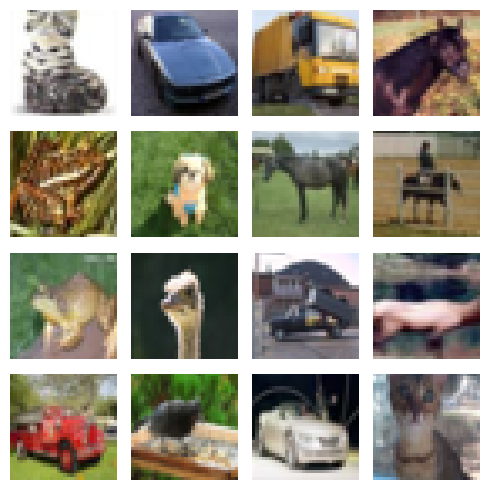

In [78]:
indices = np.random.choice(len(train_dataset), 16, replace=False)
sample_images = [train_dataset[i][0] for i in indices]

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].permute(1, 2, 0).numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()

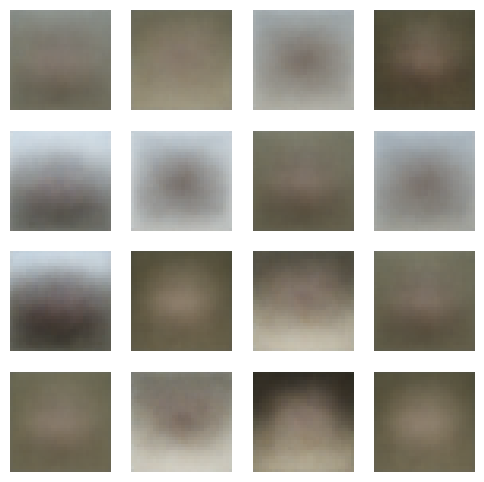

In [69]:
vae_conv.eval()
with torch.no_grad():
    # Generate random samples from latent space
    z = torch.randn(16, latent_dim)  # Sample from standard normal
    generated_images = vae_conv.decode(z)

# Visualize the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy().transpose(1, 2, 0))
    ax.axis('off')
plt.show()

In [70]:
grid_size = 16  # Number of points along each axis
u_range = np.linspace(0.01, 0.99, grid_size)  # Avoid 0 and 1 for numerical stability
# Compute the inverse CDF (quantile function) for the grid
z_coords = norm.ppf(u_range)  # Maps uniform probabilities to Gaussian values
# Create a grid of latent points
z_grid = np.array([[z1, z2] for z1 in z_coords for z2 in z_coords])
# Convert the grid to a PyTorch tensor
z_grid_tensor = torch.tensor(z_grid, dtype=torch.float32)

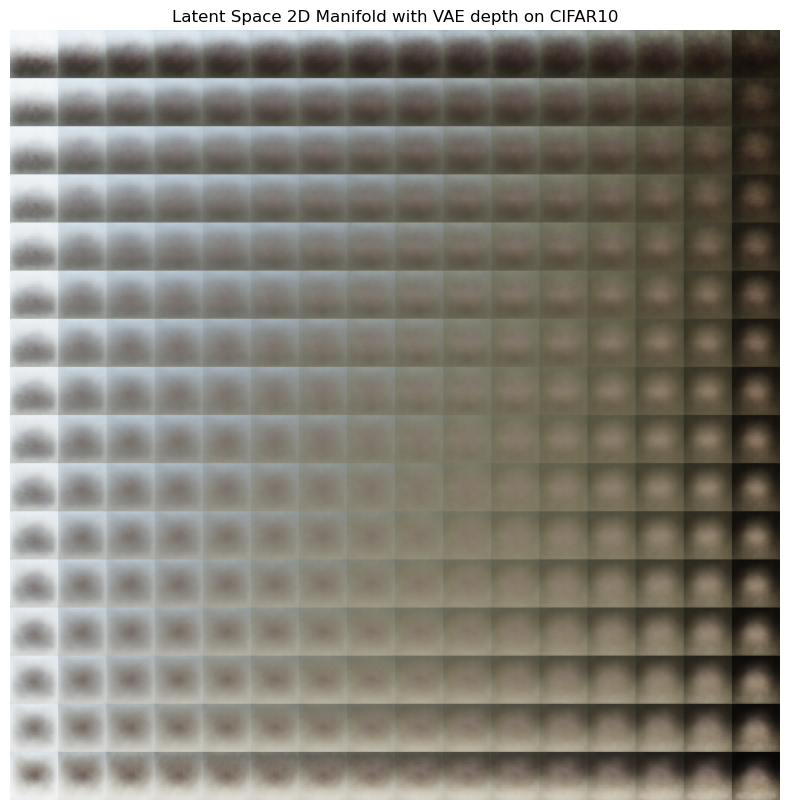

In [76]:
vae_conv.eval()
with torch.no_grad():
    generated_images = vae_conv.decode(z_grid_tensor)

# Visualize the manifold
img_dim = 32 # Assuming MNIST
canvas = np.zeros((grid_size * img_dim, grid_size * img_dim,3))

for i, (z1, z2) in enumerate(z_grid):
    x = i % grid_size
    y = i // grid_size
    img = generated_images[i].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    canvas[y*img_dim:(y+1)*img_dim, x*img_dim:(x+1)*img_dim] = img
plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.title('Latent Space 2D Manifold with VAE depth on CIFAR10')
plt.axis('off')
plt.show()